In [4]:
!pip uninstall -y numpy


Found existing installation: numpy 2.3.1
Uninstalling numpy-2.3.1:
  Successfully uninstalled numpy-2.3.1


In [5]:
!pip install numpy==1.25.2


  Using cached numpy-1.25.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.6 kB)
Using cached numpy-1.25.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.2 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 1.25.2 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.25.2 which is incompatible.
ydf 0.12.0 requires protobuf<6.0.0,>=5.29.1, but you have protobuf 4.25.8 which is incompatible.
orbax-checkpoint 0.11.16 requires jax>=0.5.0, but you have jax 0.4.30 which is incompatible.
tensorflow-decision-forests 1.11.0 requires tensorflow==2.18.0, but you have tensorflow 2.12.0 which is incompatible.
tensorflow-text 2.18.1 requires tensorflow<2.19,>=2.18.0, but you have tensorflow 2.12.0 which is incompatible.
tf-keras 2.18.0 req

In [ ]:
!pip install imgaug


Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/commands/install.py", line 447, in run
    conflicts = self._determine_conflicts(to_install)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/commands/install.py", line 578, in _determine_conflicts
    return check_install_conflicts(to_install)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/operations/check.py", line 101, in check_install_conflicts
^C


In [1]:
import os
import glob
import h5py
import shutil
import imgaug as aug
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mimg
import imgaug.augmenters as iaa
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from PIL import Image
from pathlib import Path
from skimage.io import imread
from skimage.transform import resize
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D
from keras.layers import GlobalMaxPooling2D
from keras.layers import BatchNormalization
from keras.layers import Concatenate
from keras.models import Model
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import cv2
from keras import backend as K
color = sns.color_palette()
%matplotlib inline

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
os.listdir()

# Any results you write to the current directory are saved as output.

['.config',
 'best_model_todate.data-00000-of-00001',
 'checkpoint',
 'best_model_todate.index',
 'drive',
 'sample_data']

In [2]:
import imgaug as aug
import imgaug.augmenters as iaa
print("imgaug is now working with numpy!")

imgaug is now working with numpy!


In [3]:
from keras.layers import BatchNormalization

In [4]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

# Set the random seed for numpy
import numpy as np
np.random.seed(0)

# Set the random seed for tensorflow
tf.set_random_seed(0)

# Disable multi-threading in tensorflow ops
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

# Set the random seed in tensorflow at graph level
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)

# Set the keras session to the created tensorflow session
from keras import backend as K

Instructions for updating:
non-resource variables are not supported in the long term


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# Define path to the data directory
data_dir = Path('/content/drive/MyDrive/OCT2017')

# Path to train directory (Fancy pathlib...no more os.path!!)
train_dir = data_dir / 'Train'

# Path to test directory
test_dir = data_dir / 'test'

In [7]:
# Get the path to the cnv,dme,drusen and normal sub-directories
cnv_cases_dir = train_dir / 'CNV'
dme_cases_dir = train_dir / 'DME'
drusen_cases_dir = train_dir / 'DRUSEN'
normal_cases_dir = train_dir / 'NORMAL'

# Get the list of all the images
cnv_cases = cnv_cases_dir.glob('*.jpeg')
dme_cases = dme_cases_dir.glob('*.jpeg')
drusen_cases = drusen_cases_dir.glob('*.jpeg')
normal_cases = normal_cases_dir.glob('*.jpeg')

# An empty list. We will insert the data into this list in (img_path, label) format
train_data = []

# Go through all the cnv cases. The label for these cases will be 0
for img in cnv_cases:
    train_data.append((img,0))

# Go through all the dme cases. The label for these cases will be 1
for img in dme_cases:
    train_data.append((img, 1))
# Go through all the drusen cases. The label for these cases will be 0
for img in drusen_cases:
    train_data.append((img,0))

# Go through all the normal cases. The label for these cases will be 1
for img in normal_cases:
    train_data.append((img, 1))

# Get a pandas dataframe from the data we have in our list
train_data = pd.DataFrame(train_data, columns=['image', 'label'],index=None)

# Shuffle the data
train_data = train_data.sample(frac=1.).reset_index(drop=True)

# How the dataframe looks like?
print("Total samples:", len(train_data))
print(train_data.head())


Total samples: 3130
                                               image  label
0  /content/drive/MyDrive/OCT2017/Train/DME/DME-1...      1
1  /content/drive/MyDrive/OCT2017/Train/DRUSEN/DR...      0
2  /content/drive/MyDrive/OCT2017/Train/DME/DME-1...      1
3  /content/drive/MyDrive/OCT2017/Train/DME/DME-1...      1
4  /content/drive/MyDrive/OCT2017/Train/CNV/CNV-1...      0


/tmp/ipython-input-8-4141126973.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cases_count.index, y=cases_count.values, palette=color)


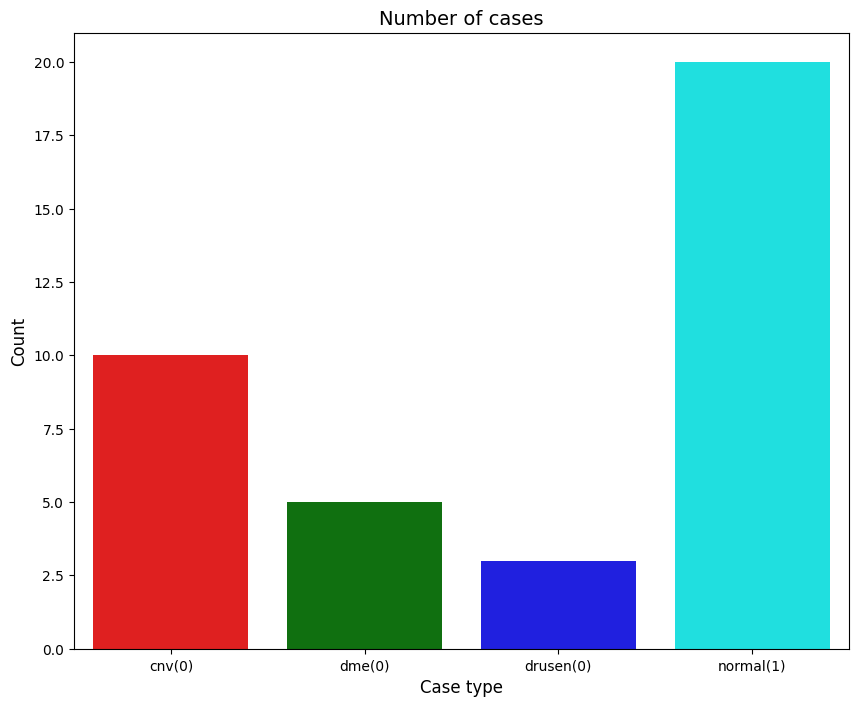

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create a sample dataframe
df = pd.DataFrame({
    'label': ['cnv(0)', 'dme(0)', 'drusen(0)', 'normal(1)'],
    'value': [10, 5, 3, 20]
})

# Create a series from the dataframe
cases_count = df.set_index('label')['value']
color = ['red', 'green', 'blue', 'cyan']
# Plot the results
plt.figure(figsize=(10,8))
sns.barplot(x=cases_count.index, y=cases_count.values, palette=color)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(cases_count.index)), cases_count.index)
plt.show()

/content


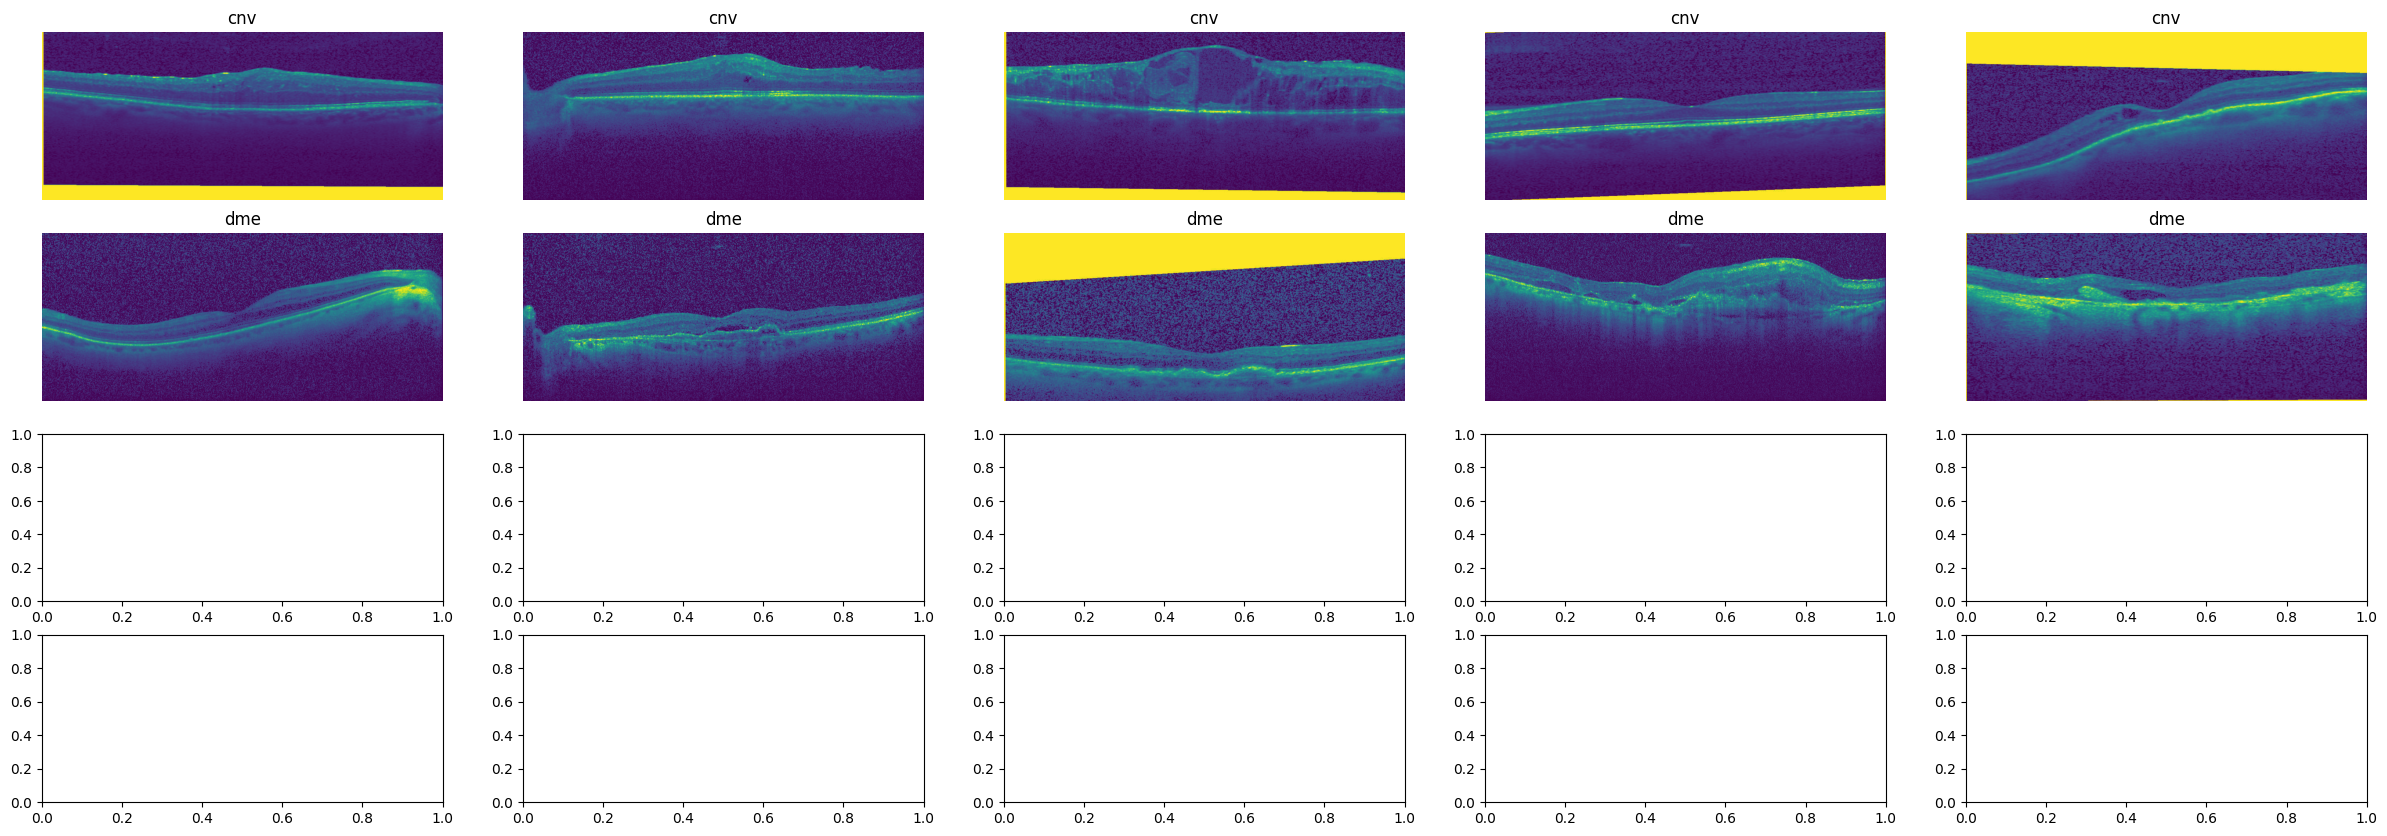

10


In [9]:
import matplotlib.pyplot as plt
from skimage.io import imread
import pandas as pd
import os
print(os.getcwd())


# Get few samples for both the classes
cnv_samples = (train_data[train_data['label']==1]['image'].iloc[:5]).tolist()
dme_samples = (train_data[train_data['label']==0]['image'].iloc[:5]).tolist()
drusen_samples = (train_data[train_data['label']==2]['image'].iloc[:5]).tolist()
normal_samples = (train_data[train_data['label']==3]['image'].iloc[:5]).tolist()

# Concat the data in a single list and del the above four lists
samples = cnv_samples + dme_samples + drusen_samples + normal_samples

# Plot the data
f, ax = plt.subplots(4,5, figsize=(30,10))
for i in range(10):
      img = imread(samples[i])
      ax[i//5, i%5].imshow(img, cmap=None)
      if i < 5:
        ax[i//5, i%5].set_title("cnv")
      elif i<10:
        ax[i//5, i%5].set_title("dme")
      elif i < 15:
        ax[i//5, i%5].set_title("drusen")
      else:
        ax[i//5, i%5].set_title("normal")
      ax[i//5, i%5].axis('off')
      ax[i//5, i%5].set_aspect('auto')
plt.show()

print(len(samples))

In [10]:
from pathlib import Path
import cv2
import numpy as np
from tensorflow.keras.utils import to_categorical

# Define the paths
base_dir = Path('/content/drive/MyDrive/OCT2017')
train_dir = base_dir / 'Train'
val_dir = base_dir / 'test'

# Corrected sub-dir paths
cnv_cases_dir = train_dir / 'CNV'
dme_cases_dir = train_dir / 'DME'
drusen_cases_dir = train_dir / 'DRUSEN'
normal_cases_dir = train_dir / 'NORMAL'

# Count images
print('CNV images:', len(list(cnv_cases_dir.glob('*.jpeg'))))
print('DME images:', len(list(dme_cases_dir.glob('*.jpeg'))))
print('DRUSEN images:', len(list(drusen_cases_dir.glob('*.jpeg'))))
print('NORMAL images:', len(list(normal_cases_dir.glob('*.jpeg'))))

# Get the list
cnv_cases = cnv_cases_dir.glob('*.jpeg')
dme_cases = dme_cases_dir.glob('*.jpeg')
drusen_cases = drusen_cases_dir.glob('*.jpeg')
normal_cases = normal_cases_dir.glob('*.jpeg')

valid_data = []
valid_labels = []

# CNV = 0
for img in cnv_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] == 1:
        img = np.dstack([img]*3)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(0, num_classes=4)
    valid_data.append(img)
    valid_labels.append(label)

# DME = 1
for img in dme_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] == 1:
        img = np.dstack([img]*3)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(1, num_classes=4)
    valid_data.append(img)
    valid_labels.append(label)

# DRUSEN = 2
for img in drusen_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] == 1:
        img = np.dstack([img]*3)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(2, num_classes=4)
    valid_data.append(img)
    valid_labels.append(label)

# NORMAL = 3
for img in normal_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] == 1:
        img = np.dstack([img]*3)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(3, num_classes=4)
    valid_data.append(img)
    valid_labels.append(label)

valid_data = np.array(valid_data)
valid_labels = np.array(valid_labels)

print("Total number of validation examples:", valid_data.shape)
print("Total number of labels:", valid_labels.shape)


CNV images: 1825
DME images: 635
DRUSEN images: 361
NORMAL images: 309
Total number of validation examples: (3130, 224, 224, 3)
Total number of labels: (3130, 4)


In [11]:
len(valid_data)

3130

In [12]:
len(valid_labels)

3130

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

In [14]:
# Augmentation sequence
seq = iaa.OneOf([
    iaa.Fliplr(), # horizontal flips
    iaa.Affine(rotate=20), # roatation
    iaa.Multiply((1.2, 1.5))]) #random brightness

In [15]:
def data_gen(data, batch_size):
    n = len(data)
    steps = n // batch_size
    batch_data = np.zeros((batch_size, 224, 224, 3), dtype=np.float32)
    batch_labels = np.zeros((batch_size, 2), dtype=np.float32)
    indices = np.arange(n)
    i = 0

    while True:
        np.random.shuffle(indices)
        count = 0
        next_batch = indices[(i * batch_size):(i + 1) * batch_size]

        for j, idx in enumerate(next_batch):
            img_name = data.iloc[idx]['image']
            label = data.iloc[idx]['label']

            encoded_label = to_categorical(label, num_classes=2)
            img = cv2.imread(str(img_name))

            if img is None:
                continue  # skip corrupted/missing image

            img = cv2.resize(img, (224, 224))

            if len(img.shape) == 2 or img.shape[2] == 1:
                img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img_rgb = img_rgb.astype(np.float32) / 255.

            batch_data[count] = img_rgb
            batch_labels[count] = encoded_label

            # Class balancing via augmentation
            if label == 0 and count < batch_size - 2:
                aug_img1 = seq.augment_image(img)
                aug_img2 = seq.augment_image(img)

                aug_img1 = cv2.cvtColor(aug_img1, cv2.COLOR_BGR2RGB)
                aug_img2 = cv2.cvtColor(aug_img2, cv2.COLOR_BGR2RGB)

                aug_img1 = aug_img1.astype(np.float32) / 255.
                aug_img2 = aug_img2.astype(np.float32) / 255.

                batch_data[count + 1] = aug_img1
                batch_labels[count + 1] = encoded_label
                batch_data[count + 2] = aug_img2
                batch_labels[count + 2] = encoded_label

                count += 2
            else:
                count += 1

            if count >= batch_size:
                break

        i += 1
        yield batch_data, batch_labels

        if i >= steps:
            i = 0

In [47]:
!pip install tensorflow==2.12


INFO: pip is looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.0/586.0 MB 793.7 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 48.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 36.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 57.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 61.9 MB/s eta 0:00:00


In [16]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, SeparableConv2D, BatchNormalization
from tensorflow.keras.models import Model

def build_model():
    input_img = Input(shape=(224, 224, 3), name='ImageInput')

    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1_1')(input_img)
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1_2')(x)
    x = MaxPooling2D((2,2), name='pool1')(x)

    x = SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv2_1')(x)
    x = SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv2_2')(x)
    x = MaxPooling2D((2,2), name='pool2')(x)

    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_1')(x)
    x = BatchNormalization(name='bn1')(x)
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_2')(x)
    x = BatchNormalization(name='bn2')(x)
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_3')(x)
    x = MaxPooling2D((2,2), name='pool3')(x)

    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_1')(x)
    x = BatchNormalization(name='bn3')(x)
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_2')(x)
    x = BatchNormalization(name='bn4')(x)
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_3')(x)
    x = MaxPooling2D((2,2), name='pool4')(x)

    x = Flatten(name='flatten')(x)
    x = Dense(1024, activation='relu', name='fc1')(x)
    x = Dropout(0.7, name='dropout1')(x)
    x = Dense(512, activation='relu', name='fc2')(x)
    x = Dropout(0.5, name='dropout2')(x)
    x = Dense(4, activation='softmax', name='fc3')(x)

    model = Model(inputs=input_img, outputs=x)
    return model


In [17]:
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

# Build and summarize the model
model = build_model()
model.summary()

Instructions for updating:
Colocations handled automatically by placer.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ImageInput (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 Conv1_1 (Conv2D)            (None, 224, 224, 64)      1792      
                                                                 
 Conv1_2 (Conv2D)            (None, 224, 224, 64)      36928     
                                                                 
 pool1 (MaxPooling2D)        (None, 112, 112, 64)      0         
                                                                 
 Conv2_1 (SeparableConv2D)   (None, 112, 112, 128)     8896      
                                                                 
 Conv2_2 (SeparableConv2D)   (None, 112, 112, 128)     17664     
                                                                 
 pool2 (MaxPooling2D)        (None, 56, 56, 128)       0     

In [18]:
!pip install h5py

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
import os
os.path.exists('//content//drive//MyDrive//oct//vgg16_weights_tf_dim_ordering_tf_kernels.h5')


True

In [21]:
from tensorflow.keras.models import load_model
import h5py
# Open the VGG16 weight file
f = h5py.File('/content/drive/MyDrive/oct/vgg16_weights_tf_dim_ordering_tf_kernels.h5', 'r')


# Select the layers for which you want to set weight.

w,b = f['block1_conv1']['block1_conv1_W_1:0'], f['block1_conv1']['block1_conv1_b_1:0']
model.layers[1].set_weights = [w,b]

w,b = f['block1_conv2']['block1_conv2_W_1:0'], f['block1_conv2']['block1_conv2_b_1:0']
model.layers[2].set_weights = [w,b]

w,b = f['block2_conv1']['block2_conv1_W_1:0'], f['block2_conv1']['block2_conv1_b_1:0']
model.layers[4].set_weights = [w,b]

w,b = f['block2_conv2']['block2_conv2_W_1:0'], f['block2_conv2']['block2_conv2_b_1:0']
model.layers[5].set_weights = [w,b]

f.close()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ImageInput (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 Conv1_1 (Conv2D)            (None, 224, 224, 64)      1792      
                                                                 
 Conv1_2 (Conv2D)            (None, 224, 224, 64)      36928     
                                                                 
 pool1 (MaxPooling2D)        (None, 112, 112, 64)      0         
                                                                 
 Conv2_1 (SeparableConv2D)   (None, 112, 112, 128)     8896      
                                                                 
 Conv2_2 (SeparableConv2D)   (None, 112, 112, 128)     17664     
                                                                 
 pool2 (MaxPooling2D)        (None, 56, 56, 128)       0     

In [22]:
!pip install Adam

In [23]:
# opt = RMSprop(lr=0.0001, decay=1e-6)

opt = Adam(lr=0.0001)
es = EarlyStopping(patience=5)
chkpt = ModelCheckpoint(filepath='best_model_todate', save_best_only=True, save_weights_only=True)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [24]:
data_gen = ImageDataGenerator(rescale=1./255)
batch_size = 32
nb_epochs = 1
# Get a train data generator
train_data_gen = data_gen.flow_from_directory("/content/drive/MyDrive/OCT2017/Train/",target_size=(224,224), batch_size= 32)

# Define the number of training steps
nb_train_steps = valid_data.shape[0]//batch_size
nb_validation_steps = valid_data.shape[0]//batch_size

print("Number of training and validation steps: {} and {}".format(nb_train_steps, len(valid_data)))

Found 3130 images belonging to 4 classes.
Number of training and validation steps: 97 and 3130


In [25]:
train_data_gen

In [26]:
print(train_data['label'].unique())


[1 0]


In [27]:
print(valid_data.shape)
print(valid_labels.shape)

(3130, 224, 224, 3)
(3130, 4)


In [28]:
history = model.fit(
    train_data_gen,
    epochs=nb_epochs,
    steps_per_epoch=nb_train_steps,
    validation_data=(valid_data, valid_labels),
    validation_steps=nb_validation_steps,
    callbacks=[es, chkpt],
    class_weight={0:1.0, 1:0.4, 2:0.4, 3:0.4}
)

97/97 [==============================] - ETA: 0s - batch: 48.0000 - size: 31.9381 - loss: 0.6266 - acc: 0.5813 

/usr/local/lib/python3.11/dist-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


97/97 [==============================] - 4036s 41s/step - batch: 48.0000 - size: 31.9381 - loss: 0.6266 - acc: 0.5813 - val_loss: 1.1815 - val_acc: 0.5831


In [28]:
# Save the model
model.save('/content/drive/MyDrive/oct/Saved Model/model.h5')


In [35]:
!pip Job lib

ERROR: unknown command "Job"


In [29]:
# Load the model weights
from tensorflow.keras.models import load_model
model = load_model("/content/drive/MyDrive/oct/Saved Model/my_model.h5")
model.load_weights("/content/drive/MyDrive/oct/Saved Model/my_model.h5")


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [30]:
# Preparing test data
val_dir =  'CNV'
val_dir =  'DME'
val_dir =  'DRUSEN'
val_dir =  'NORMAL'

# Print the number of images in each sub-directory
print('CNV images:', len(list(cnv_cases_dir.glob('*.jpeg'))))
print('DME images:', len(list(dme_cases_dir.glob('*.jpeg'))))
print('DRUSEN images:', len(list(drusen_cases_dir.glob('*.jpeg'))))
print('NORMAL images:', len(list(normal_cases_dir.glob('*.jpeg'))))

# Get the list of all the images
cnv_cases = cnv_cases_dir.glob('*.jpeg')
dme_cases = dme_cases_dir.glob('*.jpeg')
drusen_cases = drusen_cases_dir.glob('*.jpeg')
normal_cases = normal_cases_dir.glob('*.jpeg')


test_data = []
test_labels = []

for img in cnv_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(0, num_classes=2)
    test_data.append(img)
    test_labels.append(label)

for img in dme_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(1, num_classes=2)
    test_data.append(img)
    test_labels.append(label)

for img in drusen_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(1, num_classes=2)
    test_data.append(img)
    test_labels.append(label)

for img in normal_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(1, num_classes=2)
    test_data.append(img)
    test_labels.append(label)


test_data = np.array(test_data)
test_labels = np.array(test_labels)

print("Total number of test examples: ", test_data.shape)
print("Total number of labels:", test_labels.shape)

CNV images: 1825
DME images: 635
DRUSEN images: 361
NORMAL images: 309
Total number of test examples:  (3130, 224, 224, 3)
Total number of labels: (3130, 2)


In [31]:
# Evaluation on test dataset
test_loss, test_score = model.evaluate(test_data, test_labels, batch_size=32)
print("Loss on test set: ", test_loss)
print("Accuracy on test set: ", test_score)

/usr/local/lib/python3.11/dist-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


Loss on test set:  0.44752021281483073
Accuracy on test set:  0.85047925


In [32]:
# Get predictions
preds = model.predict(test_data, batch_size=16)
preds = np.argmax(preds, axis=-1)

# Original labels
orig_test_labels = np.argmax(test_labels, axis=-1)

print(orig_test_labels.shape)
print(preds.shape)

/usr/local/lib/python3.11/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


(3130,)
(3130,)


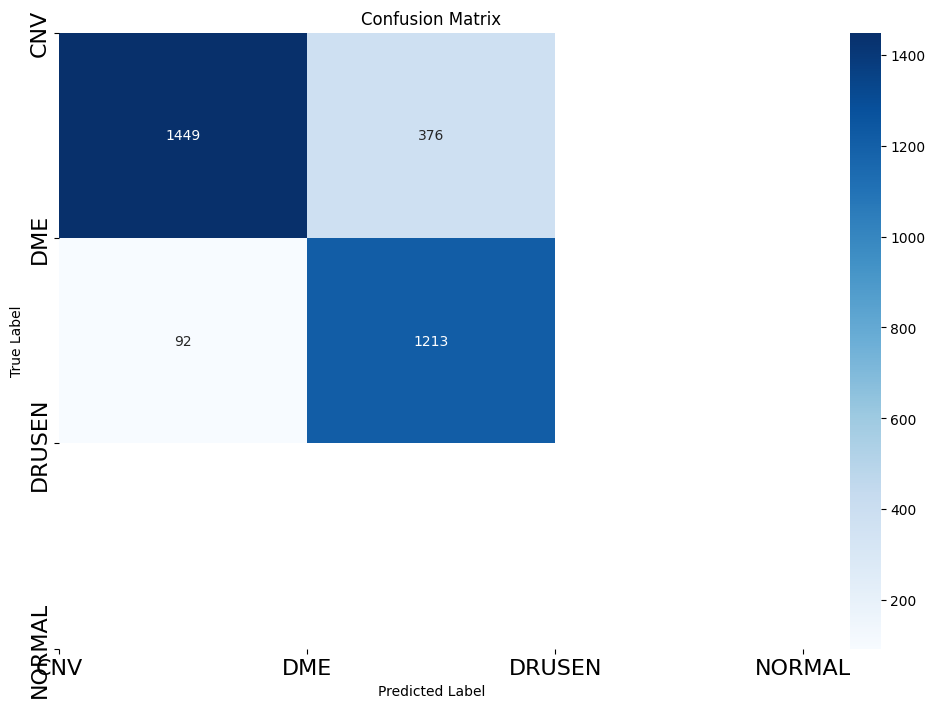

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(orig_test_labels, preds)

# Plot confusion matrix using seaborn
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xticks(range(4), ['CNV', 'DME', 'DRUSEN', 'NORMAL'], fontsize=16)
plt.yticks(range(4), ['CNV', 'DME', 'DRUSEN', 'NORMAL'], fontsize=16)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [34]:
# Calculate Precision and Recall
tn, fp, fn, tp = cm.ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)

print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))

Recall of the model is 0.93
Precision of the model is 0.76
